In [2]:
from fastai.tabular import *
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
import pprint
from sklearn.utils import shuffle
p = pprint.PrettyPrinter(indent=4, width=30)
pretty = p.pprint

print('libraries loaded')

libraries loaded


In [3]:
def loadData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # Note: there's a leading space for each column name except for the first one
        # let's strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        df.drop(columns=['Source IP', 'Destination IP'], inplace=True)
        # drop missing values/NaN etc.
        df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
        for col in ndf.columns:
            indexNames = ndf[ndf[col] == np.inf].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                ndf.drop(indexNames, inplace=True)

            indexNames = ndf[ndf[col] == np.nan].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                ndf.drop(indexNames, inplace=True)

            indexNames = ndf[ndf[col]=='Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                ndf.drop(indexNames, inplace=True)

            indexNames = ndf[ndf[col]=='inf'].index
            if not indexNames.empty:
                print('deleting {} rows with inf in column {}'.format(len(indexNames), col))
                ndf.drop(indexNames, inplace=True)

            indexNames = ndf[ndf[col]=='NaN'].index
            if not indexNames.empty:
                print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
                ndf.drop(indexNames, inplace=True)

            indexNames = ndf[ndf[col]=='nan'].index
            if not indexNames.empty:
                print('deleting {} rows with nan in column {}'.format(len(indexNames), col))
                ndf.drop(indexNames, inplace=True)
        # convert  Flow Bytes/s object & Flow Packets/s object into float type
        df['Flow Bytes/s'] = df['Flow Bytes/s'].astype('float64')
        df['Flow Packets/s'] = df['Flow Packets/s'].astype('float64')
        print(df.tail())
        df.to_pickle(pickleDump)
    
    return df

In [4]:
print('relevant libraries uploaded')

# Choose your own filepath for arff file
filepath = 'CICDataSet-TOR/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR.csv'
#raw_data = loadarff(filepath)
df_data = pd.read_csv(filepath)
# Converting arff file into pandas dataframe
#df_data = pd.DataFrame(raw_data[0])

# Now, you can perform pandas methods if it is easy enough for you
#print(df_data['class1'].value_counts())
#column_name = list(df_data.columns)
#print(column_name)


relevant libraries uploaded


In [5]:
df_data

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,117202678,17,4,35188437,35149142,4.742976e+05,5.578672e+05,2.502257e+06,2.693576e+06,3.916293,...,1.839548e+06,1363299,5.561680e+06,35334176,7.589073e+06,1079974,4.426667e+06,35137650,7.605741e+06,NONTOR
1,119579137,16,4,35208950,35022877,5.108043e+05,5.410036e+05,2.582052e+06,2.634447e+06,3.821737,...,1.849452e+06,1443143,4.972742e+06,35280803,7.131588e+06,1065834,4.185795e+06,35022877,7.108954e+06,NONTOR
2,90462788,20,5,24383019,24244301,9.812504e+05,1.145099e+06,3.866535e+06,4.125707e+06,1.912389,...,2.842532e+06,2757283,9.991859e+06,24613894,8.779228e+06,1297996,9.071855e+06,24244301,9.259661e+06,NONTOR
3,65341087,18,5,26116331,25978548,6.873223e+05,7.503962e+05,3.213452e+06,3.322049e+06,2.815992,...,2.313499e+06,1566070,9.245735e+06,26194797,9.349672e+06,1197148,8.231822e+06,25978548,9.321698e+06,NONTOR
4,119999180,29999272,29999277,30001029,30001305,3.000000e+07,3.000000e+07,8.268222e+02,1.154763e+03,0.075001,...,1.600000e+07,29999272,3.000000e+07,30001029,8.268222e+02,29944247,2.990000e+07,29944585,1.499153e+02,NONTOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11247,119995943,119995707,119995733,103,15,7.682500e+04,7.686000e+04,4.502653e+04,3.560704e+04,50.310034,...,2.242562e+04,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,TOR
11248,119958872,119958644,119958872,36,14,7.693900e+04,7.550700e+04,4.620903e+04,3.602369e+04,49.416937,...,2.264742e+04,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,TOR
11249,119933641,119931440,119933641,72,13,7.668800e+04,7.598000e+04,4.556666e+04,3.653172e+04,49.335616,...,2.302657e+04,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,TOR
11250,119990715,119990521,119990414,44,14,7.710100e+04,7.680700e+04,4.529653e+04,3.684078e+04,49.237143,...,2.303008e+04,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,TOR


In [6]:
# total Tor samples
df_data['class1'].value_counts()
df_data.dtypes

duration                int64
total_fiat              int64
total_biat              int64
min_fiat                int64
min_biat                int64
max_fiat              float64
max_biat              float64
mean_fiat             float64
mean_biat             float64
flowPktsPerSecond     float64
flowBytesPerSecond    float64
min_flowiat             int64
max_flowiat             int64
mean_flowiat          float64
std_flowiat           float64
min_active              int64
mean_active           float64
max_active              int64
std_active            float64
min_idle                int64
mean_idle             float64
max_idle                int64
std_idle              float64
class1                 object
dtype: object

In [7]:
df_dep_var = 'class1'
#df_cat_names = ['duration', 'total_fiat', 'total_biat']
cont_names = list(set(df_data.columns) - set([df_dep_var]))

In [8]:
cont_names

['flowBytesPerSecond',
 'max_fiat',
 'total_fiat',
 'duration',
 'flowPktsPerSecond',
 'mean_active',
 'min_fiat',
 'max_idle',
 'std_idle',
 'mean_biat',
 'min_active',
 'total_biat',
 'mean_fiat',
 'min_flowiat',
 'mean_idle',
 'max_biat',
 'min_biat',
 'std_active',
 'max_flowiat',
 'mean_flowiat',
 'min_idle',
 'max_active',
 'std_flowiat']

In [9]:
procs = [FillMissing, Categorify, Normalize]
sss = StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.2,
            train_size=None)


epoch,train_loss,valid_loss,accuracy,time
0,0.512608,0.363043,0.995113,00:01
1,0.147570,0.038578,0.999112,00:01
2,0.027574,0.017099,0.998667,00:01
3,0.005708,0.004343,0.999556,00:01
4,0.005201,0.003894,0.999556,00:01
5,0.001657,0.003720,0.999556,00:01
6,0.004785,0.004583,0.999556,00:01
7,0.003115,0.003080,0.999556,00:01
8,0.002261,0.003270,0.999556,00:01
9,0.002333,0.003035,0.999556,00:01


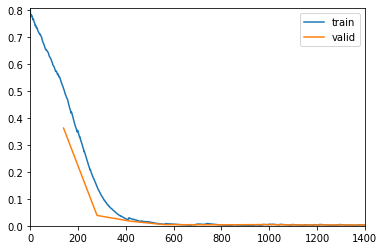

epoch,train_loss,valid_loss,accuracy,time
0,0.530471,0.405771,0.988450,00:01
1,0.151930,0.049403,0.998667,00:01
2,0.021678,0.009739,0.999112,00:01
3,0.004263,0.007070,0.999112,00:01
4,0.016974,0.009251,0.999112,00:01
5,0.002888,0.006811,0.999112,00:01
6,0.005002,0.007370,0.999112,00:01
7,0.004466,0.006549,0.999112,00:01
8,0.002701,0.006242,0.999112,00:01
9,0.003566,0.006466,0.999112,00:01


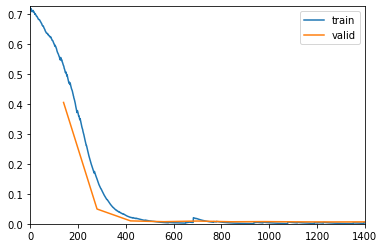

In [10]:
for train_idx, test_idx in sss.split(df_data.index, df_data[df_dep_var]):
    data_fold = (TabularList.from_df(df_data, path=filepath, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=df_dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
   # model.save('{}.model'.format(os.path.basename(filepath)))

In [11]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.006466029677540064: accuracy: 99.91%


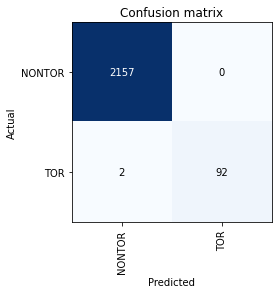

In [12]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix()

In [23]:
print('relevant libraries uploaded')

# Choose your own filepath for arff file
filepath = 'CICDataSet-TOR/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR.csv'
#raw_data = loadarff(filepath)
df_data = pd.read_csv(filepath)
# Converting arff file into pandas dataframe
#df_data = pd.DataFrame(raw_data[0])

# Now, you can perform pandas methods if it is easy enough for you
#print(df_data['class1'].value_counts())
#column_name = list(df_data.columns)
#print(column_name)


relevant libraries uploaded


In [24]:
df_data

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,76,-1,-1,-1,-1,0.0,0.0,0.000000,0.000000,26315.789474,...,0.000000e+00,-1,0.0,-1,0.0,-1,0.0,-1,0.0,NONTOR
1,54,-1,-1,-1,-1,0.0,0.0,0.000000,0.000000,37037.037037,...,0.000000e+00,-1,0.0,-1,0.0,-1,0.0,-1,0.0,NONTOR
2,67,-1,-1,-1,-1,0.0,0.0,0.000000,0.000000,29850.746269,...,0.000000e+00,-1,0.0,-1,0.0,-1,0.0,-1,0.0,NONTOR
3,75,-1,-1,-1,-1,0.0,0.0,0.000000,0.000000,26666.666667,...,0.000000e+00,-1,0.0,-1,0.0,-1,0.0,-1,0.0,NONTOR
4,14512571,14512571,-1,14512571,-1,14500000.0,0.0,0.000000,0.000000,0.206717,...,1.030000e+07,14512571,14500000.0,14512571,0.0,14512502,14500000.0,14512502,0.0,NONTOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16424,59938510,59938322,59938192,73,13,76069.0,75289.0,45168.290882,36194.560386,49.801038,...,2.294679e+04,-1,0.0,-1,0.0,-1,0.0,-1,0.0,TOR
16425,59997670,59997422,59997438,72,14,76688.0,75980.0,45939.833078,36898.793358,48.901899,...,2.311295e+04,-1,0.0,-1,0.0,-1,0.0,-1,0.0,TOR
16426,59995525,59995303,59995335,168,20,76435.0,76482.0,44873.076290,36784.386879,49.503692,...,2.305440e+04,-1,0.0,-1,0.0,-1,0.0,-1,0.0,TOR
16427,59995452,59995175,59995216,44,14,77101.0,76807.0,45658.428463,36784.313918,49.120390,...,2.294604e+04,-1,0.0,-1,0.0,-1,0.0,-1,0.0,TOR


In [25]:
# total Tor samples
df_data['class1'].value_counts()
df_data.dtypes

duration                int64
total_fiat              int64
total_biat              int64
min_fiat                int64
min_biat                int64
max_fiat              float64
max_biat              float64
mean_fiat             float64
mean_biat             float64
flowPktsPerSecond     float64
flowBytesPerSecond    float64
min_flowiat             int64
max_flowiat             int64
mean_flowiat          float64
std_flowiat           float64
min_active              int64
mean_active           float64
max_active              int64
std_active            float64
min_idle                int64
mean_idle             float64
max_idle                int64
std_idle              float64
class1                 object
dtype: object

epoch,train_loss,valid_loss,accuracy,time
0,0.463545,0.303981,0.998174,00:01
1,0.055729,0.014801,0.999087,00:01
2,0.008358,0.006937,0.998783,00:01
3,0.005026,0.007382,0.998478,00:01
4,0.007220,0.005261,0.999087,00:02
5,0.004769,0.004676,0.999087,00:01
6,0.002300,0.013996,0.998783,00:01
7,0.001806,0.007088,0.998783,00:01
8,0.005064,0.016697,0.998478,00:01
9,0.004236,0.013812,0.998478,00:02


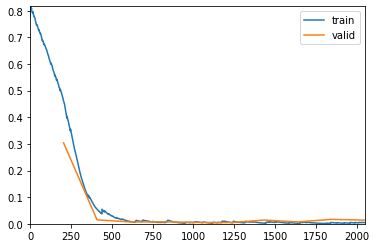

epoch,train_loss,valid_loss,accuracy,time
0,0.549507,0.370181,0.995435,00:01
1,0.060249,0.010646,0.999696,00:02
2,0.010503,0.004129,0.999087,00:01
3,0.010746,0.056407,0.996957,00:02
4,0.004869,0.035001,0.998174,00:01
5,0.003609,0.010918,0.999391,00:02
6,0.002347,0.000346,0.999696,00:02
7,0.004989,0.016904,0.999087,00:01
8,0.003473,0.004780,0.999696,00:02
9,0.003694,0.055090,0.996652,00:01


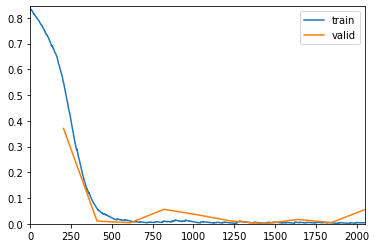

In [26]:
for train_idx, test_idx in sss.split(df_data.index, df_data[df_dep_var]):
    data_fold = (TabularList.from_df(df_data, path=filepath, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=df_dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
   # model.save('{}.model'.format(os.path.basename(filepath)))

In [27]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.05508989468216896: accuracy: 99.67%


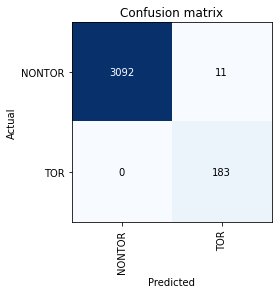

In [28]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix()

In [29]:

print('relevant libraries uploaded')

# Choose your own filepath for arff file
filepath = 'CICDataSet-TOR/Scenario-A/TimeBasedFeatures-30s-TORNonTOR.csv'
#raw_data = loadarff(filepath)
df_data = pd.read_csv(filepath)
# Converting arff file into pandas dataframe
#df_data = pd.DataFrame(raw_data[0])

# Now, you can perform pandas methods if it is easy enough for you
#print(df_data['class1'].value_counts())
#column_name = list(df_data.columns)
#print(column_name)


relevant libraries uploaded


In [30]:
df_data

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,22930417,18,4,10995965,10960941,314115.301370,360993.158730,1.306745e+06,1.389355e+06,6.018207,...,952994.511204,1491627,5.011278e+06,11141326,4.507600e+06,1079974,3.668800e+06,10945954,4.855368e+06,NONTOR
1,25199304,16,4,11037969,10851858,359269.900000,387414.676923,1.373362e+06,1.392885e+06,5.436658,...,976395.388090,1710925,4.164396e+06,14269600,4.973926e+06,1234883,3.150269e+06,10851858,3.797336e+06,NONTOR
2,29772995,17,7,4093396,3956161,261815.256637,310135.364583,6.445422e+05,6.512717e+05,7.086959,...,462297.947930,1363299,2.706523e+06,6192566,1.445372e+06,1147658,1.955468e+06,3956161,8.938483e+05,NONTOR
3,29609149,22,6,3954677,3943698,271180.963303,287136.446602,6.685474e+05,6.590460e+05,7.227496,...,472527.270988,1443143,2.937555e+06,4176130,8.769669e+05,1065834,2.022585e+06,3895269,9.303813e+05,NONTOR
4,7863522,30,8,2067690,2068091,244213.125000,252051.483871,5.718062e+05,5.628123e+05,8.266016,...,400581.170736,2092947,2.535199e+06,3282729,6.509928e+05,1707343,1.897912e+06,2017289,1.667869e+05,NONTOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16417,29998412,29998217,29998158,217,224,76011.000000,76072.000000,4.552081e+04,3.802048e+04,48.335892,...,23527.102499,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,TOR
16418,29989260,29949865,29989260,80,18,77101.000000,74790.000000,4.544744e+04,3.706954e+04,49.017548,...,23390.079904,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,TOR
16419,29945409,29945155,29944682,44,14,76259.000000,76807.000000,4.585782e+04,3.625264e+04,49.456663,...,22288.633926,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,TOR
16420,29998586,29998403,29998310,189,147,74663.000000,74055.000000,4.517832e+04,3.508574e+04,50.702390,...,21818.676424,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,-1,0.000000e+00,TOR


epoch,train_loss,valid_loss,accuracy,time
0,0.298957,0.159344,0.994825,00:02
1,0.040687,0.017679,0.997260,00:01
2,0.012306,0.011886,0.997869,00:01
3,0.010917,0.008188,0.998478,00:01
4,0.030510,0.011218,0.997260,00:01
5,0.011003,0.009317,0.998478,00:01
6,0.011248,0.008104,0.998478,00:01
7,0.006517,0.009269,0.998174,00:01
8,0.008348,0.009684,0.998174,00:01
9,0.005023,0.010692,0.997565,00:01


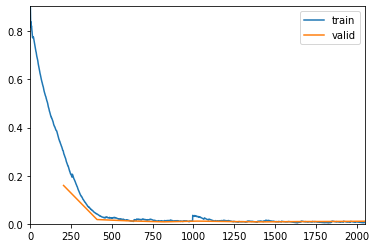

epoch,train_loss,valid_loss,accuracy,time
0,0.382915,0.213629,0.996651,00:02
1,0.043019,0.020312,0.997260,00:02
2,0.020606,0.019515,0.995738,00:02
3,0.016049,0.013556,0.997260,00:02
4,0.013771,0.014061,0.997260,00:02
5,0.016459,0.012081,0.997260,00:02
6,0.007808,0.007202,0.998174,00:01
7,0.004811,0.012284,0.997260,00:02
8,0.004562,0.008858,0.997869,00:02
9,0.004149,0.006383,0.998174,00:01


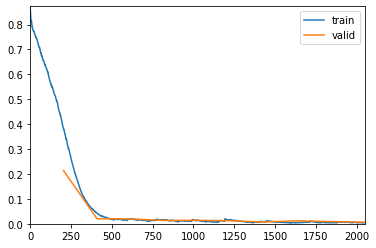

In [34]:
for train_idx, test_idx in sss.split(df_data.index, df_data[df_dep_var]):
    data_fold = (TabularList.from_df(df_data, path=filepath, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=df_dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
   # model.save('{}.model'.format(os.path.basename(filepath)))

In [35]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.006382840219885111: accuracy: 99.82%


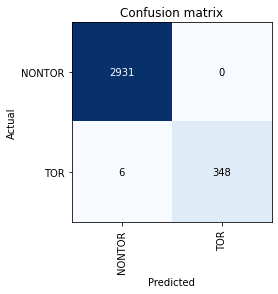

In [36]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix()

In [37]:
print('relevant libraries uploaded')

# Choose your own filepath for arff file
filepath = 'CICDataSet-TOR/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR.csv'
#raw_data = loadarff(filepath)
df_data = pd.read_csv(filepath)
# Converting arff file into pandas dataframe
#df_data = pd.DataFrame(raw_data[0])

# Now, you can perform pandas methods if it is easy enough for you
#print(df_data['class1'].value_counts())
#column_name = list(df_data.columns)
#print(column_name)


relevant libraries uploaded


In [38]:
df_data

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711,16,4,1564818,1549373,1.902053e+05,2.032905e+05,3.898224e+05,3.703237e+05,10.353612,...,2.676002e+05,1871488,1.983656e+06,2195089,1.832197e+05,1234883,1420565.0,1523088,1.610965e+05,NONTOR
1,7340238,18,4,1567554,1527893,1.656870e+05,1.869148e+05,3.172675e+05,3.043707e+05,11.580006,...,2.214629e+05,1491627,3.572433e+06,5653239,2.942704e+06,1131498,1324636.0,1517774,2.731384e+05,NONTOR
2,4644225,29,15,1270547,1079974,1.658652e+05,1.953021e+05,3.294731e+05,3.004926e+05,11.412022,...,2.174754e+05,1758922,1.758922e+06,1758922,0.000000e+00,1079974,1079974.0,1079974,0.000000e+00,NONTOR
3,4978735,19,8,2492050,2457286,2.395432e+05,2.765964e+05,6.124353e+05,6.283396e+05,8.034169,...,4.369597e+05,1710925,2.382905e+06,3054885,9.503232e+05,1346073,1894031.5,2441990,7.749303e+05,NONTOR
4,11838189,19,10,3094089,3093543,2.437665e+05,2.959547e+05,5.997218e+05,6.256327e+05,7.602514,...,4.361296e+05,1747431,2.400446e+06,3240696,6.232744e+05,1394455,1983227.0,3042717,7.259878e+05,NONTOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,13932812,13932390,13932812,93,244,8.119562e+06,8.081967e+06,3.240091e+05,2.843431e+05,6.746664,...,8.490494e+05,1506874,6.966222e+06,12425570,7.720684e+06,1469335,4775651.0,8081967,4.675837e+06,TOR
22068,14999975,14999975,14961989,0,7,1.624147e+06,1.624060e+06,2.103783e+04,2.939487e+04,81.600136,...,7.020772e+04,3249302,3.525820e+06,3802338,3.910555e+05,1288308,1456115.5,1623923,2.373156e+05,TOR
22069,14660517,14660517,14618019,333,613,7.663754e+06,7.663955e+06,1.628946e+06,1.827252e+06,1.295998,...,2.116241e+06,6381394,7.023854e+06,7666315,9.085764e+05,5314745,6489046.0,7663347,1.660712e+06,TOR
22070,14832948,14832905,14792242,7,12,7.884760e+05,8.250180e+05,4.324462e+04,4.350659e+04,46.180975,...,6.915061e+04,-1,0.000000e+00,-1,0.000000e+00,-1,0.0,-1,0.000000e+00,TOR


epoch,train_loss,valid_loss,accuracy,time
0,0.187148,0.080670,0.995017,00:03
1,0.027650,0.042787,0.993432,00:02
2,0.017666,0.015350,0.996376,00:02
3,0.010498,0.026994,0.995243,00:03
4,0.011696,0.009151,0.997508,00:04
5,0.011050,0.022167,0.995243,00:02
6,0.010711,0.022383,0.992525,00:03
7,0.010101,0.039966,0.990940,00:02
8,0.011129,0.034419,0.996149,00:02
9,0.005684,0.039687,0.995243,00:02


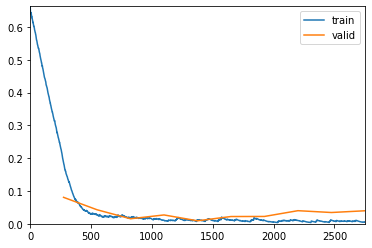

epoch,train_loss,valid_loss,accuracy,time
0,0.213644,0.127690,0.990713,00:02
1,0.027393,0.020493,0.995017,00:02
2,0.019997,0.016032,0.995923,00:02
3,0.015403,0.032757,0.994564,00:03
4,0.014910,0.038942,0.994111,00:02
5,0.011229,0.028283,0.994564,00:02
6,0.009211,0.040470,0.994111,00:02
7,0.006633,0.019762,0.995696,00:02
8,0.007887,0.030393,0.994111,00:02
9,0.005222,0.037203,0.992752,00:02


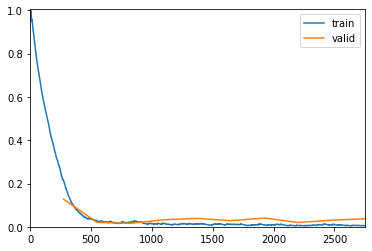

In [40]:
for train_idx, test_idx in sss.split(df_data.index, df_data[df_dep_var]):
    data_fold = (TabularList.from_df(df_data, path=filepath, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=df_dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
    #model.save('{}.model'.format(os.path.basename(filepath)))

In [41]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.03720343858003616: accuracy: 99.28%


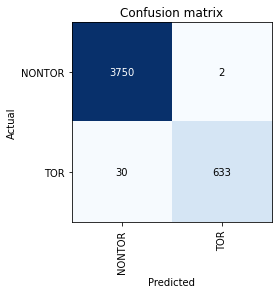

In [43]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix()

In [44]:
print('relevant libraries uploaded')

# Choose your own filepath for arff file
filepath = 'CICDataSet-TOR/Scenario-A/merged_5s.csv'
csvFile = os.path.join(filepath)
df_data = loadData(csvFile)
#df_data = pd.read_csv(filepath)


relevant libraries uploaded


In [45]:
df_dep_var = 'label'
cat_names = ['Source Port', 'Destination Port', 'Protocol']
cont_names = list(set(df_data.columns) - set(cat_names) - set([df_dep_var]))

In [46]:
cont_names

['Bwd IAT Min',
 'Flow IAT Max',
 'Fwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Idle Mean',
 'Active Std',
 'Flow IAT Min',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow Duration',
 'Idle Std',
 'Active Mean',
 'Fwd IAT Std',
 'Active Min',
 'Idle Max',
 'Flow Bytes/s',
 'Bwd IAT Std',
 'Active Max',
 'Bwd IAT Mean',
 'Idle Min',
 'Bwd IAT Max',
 'Flow Packets/s']

In [47]:
for train_idx, test_idx in sss.split(df_data.index, df_data[df_dep_var]):
    data_fold = (TabularList.from_df(df_data, path=filepath, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=df_dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
    #model.save('{}.model'.format(os.path.basename(filepath)))

NameError: name 'df' is not defined